In [1]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from IPython.display import clear_output

filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-3/B-3_AsymmDoubleSlit_Blocker2.33_14.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data[data[POSITION_COL] < 8]
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  if volt == None: volt = origninal_volt
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

device = th.device('cpu')
# pqr
P = 5
Q = 501
R = 5

DN = 140


METER = 1e6
SEC = 1

dtype = th.complex128
real = th.float64

In [2]:
th.cuda.empty_cache()
width1_t, width2_t, width3_t, width4_t = \
30e-6 * METER, 85e-6 * METER, 1778e-6 * METER, 85e-6 * METER
x1_t, x2_t = \
0.009815 * METER, 0.489 * METER

width1, width2, width3, width4 = \
th.tensor([width1_t], requires_grad=True, device=device), \
th.tensor([width2_t], requires_grad=True, device=device), \
th.tensor([width3_t], requires_grad=True, device=device), \
th.tensor([width4_t], requires_grad=True, device=device)

x1, x2 = \
th.tensor([x1_t], requires_grad=True, device=device), \
th.tensor([x2_t], requires_grad=True, device=device)

position1, position2, position3 = \
th.tensor([4e-3 * METER], requires_grad=True), \
th.tensor([4.5e-3 * METER], requires_grad=True), \
th.tensor([5e-3 * METER], requires_grad=True),

detecor_position = th.linspace(1e-3 * METER, 8e-3 * METER, DN, requires_grad=True, device=device)

LAMBDA = 670e-9 * METER
K = th.tensor([2 * np.pi / LAMBDA])
MUL = lambda x: th.exp(1j * K * x) / x

parameters = [width1, width2, width3, width4, x1, x2, position1, position2, position3]
learning_rate = 1e-4

optimizer = th.optim.SGD(parameters, lr=learning_rate)

In [3]:
def print_param_values():
  with th.no_grad():
    print("Slit <-> Blocker: ", float(x1 / METER * 1e3), "mm", "True: 9.815mm")
    print("Blocker <-> Detector: ", float(x2 / METER * 1e3), "mm", "True: 489mm")
    print("Slit Width: ", float(width1 / METER * 1e6), "µm",  float(width2 / METER * 1e6), "µm", "True: 85µm")
    print("Blocker Width: ", float(width3 / METER * 1e6), "mm", "True: 1.778mm")
    print("Detector Width: ", float(width4 / METER * 1e6), "mm", "True: 85µm")
    print("Slit Position: ", float(position1 / METER * 1e3), "mm, ", float(position2 / METER * 1e3), "mm")
    print("Inter-slit Distance: ", float(abs(position1 / METER * 1e3 - position2 / METER * 1e3)), "mm", "True: Dependss")
    print("Blocker Position: ", float(position3 / METER * 1e3), "mm")

print_param_values()

Slit <-> Blocker:  9.8149995803833 mm True: 9.815mm
Blocker <-> Detector:  489.0 mm True: 489mm
Slit Width:  30.0 µm 85.0 µm True: 85µm
Blocker Width:  1778.0 mm True: 1.778mm
Detector Width:  85.0 mm True: 85µm
Slit Position:  4.0 mm,  4.5 mm
Inter-slit Distance:  0.5 mm True: Dependss
Blocker Position:  5.0 mm


Slit <-> Blocker:  9.814123153686523 mm True: 9.815mm
Blocker <-> Detector:  489.0 mm True: 489mm
Slit Width:  -6.75146484375 µm 86.86518096923828 µm True: 85µm
Blocker Width:  1806.095703125 mm True: 1.778mm
Detector Width:  102.28692626953125 mm True: 85µm
Slit Position:  3.9229626655578613 mm,  4.576055526733398 mm
Inter-slit Distance:  0.6530928611755371 mm True: Dependss
Blocker Position:  5.001357555389404 mm


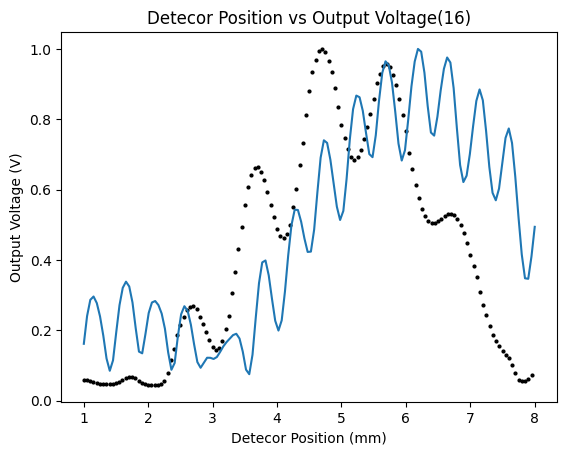

KeyboardInterrupt: 

In [7]:
for epoch in range(10000):
    field1 = th.linspace(0, 1, P, dtype=dtype, device=device) * width1 + position1
    field2 = th.linspace(0, 1, P, dtype=dtype, device=device) * width2 + position2
    field3 = th.linspace(0, 1, Q, dtype=dtype, device=device) * width3 + position3
    field4 = (th.linspace(0, 1, R, dtype=dtype, device=device) * width4)[:, None] + detecor_position[None, :]

    E1 = th.ones_like(field1, dtype=dtype, device=device) 
    E2 = th.ones_like(field2, dtype=dtype, device=device)

    D1 = th.sqrt((x1 ** 2) + 
        th.square(field1[:, None]-field3[None, :]))
    # P, Q
    D2 = th.sqrt((x1 ** 2) +
        th.square(field2[:, None]-field3[None, :]))
    # P, Q
    D3 = th.sqrt((x2 ** 2) +
        th.square(field3[:, None, None]-field4[None, ...]))
    # Q, R, DN

    E3 = th.einsum('pq,p->q', MUL(D1), E1) \
    + th.einsum('pq,p->q', MUL(D2), E2)

    result = th.sum(th.abs(th.einsum('qrn,q->rn', MUL(D3), E3)), dim=0)
    result = result / th.max(result)

    pos, volt = get_data(16)
    volt = th.tensor(volt, device=device)
    volt = volt / th.max(volt)

    error = th.sum(th.square(result - volt))
    error.backward()

    optimizer.step()
    if epoch % 100 == 0:
        with th.no_grad():
            clear_output()
            print_param_values()
            plt.plot(detecor_position.to('cpu') / METER * 1e3, result.to("cpu"))
            plot_data(16, volt)
            plt.show()


In [5]:

result = th.sum(result, dim=0)
max_val, _ = th.max(result)
result = result / max_val[..., None]
plt.plot(detecor_position / METER * 1e3, result[0, 0, 0, 0, 0, 0, 0, 0, 0,  :].to("cpu").numpy() * METER)

TypeError: iteration over a 0-d tensor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
# plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

# path = "./LASER/B-1/"
# filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-3/B-3_AsymmDoubleSlit_Blocker2.33_14.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data[data[POSITION_COL] < 8]
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  if volt == None: volt = origninal_volt
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

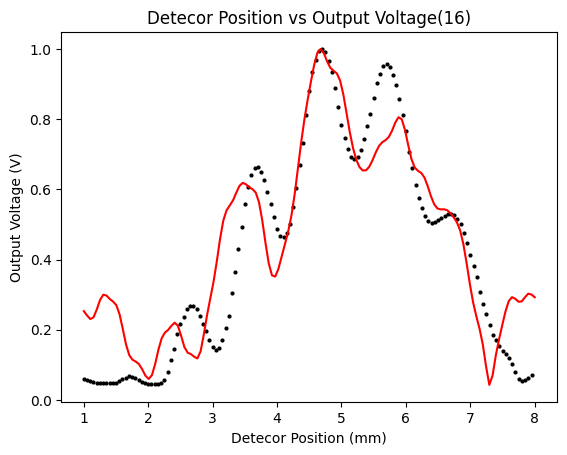

In [ ]:
pos, volt = get_data(16)
volt = np.array(volt)
volt = volt / np.max(volt)
volt = th.tensor(volt, dtype=real, device=device)
error = (th.sum(th.square(result-volt), dim=-1))
# error min 위치
arg = th.argmin(error)
plot(position4/ METER * 1e3, result.view(-1, DN)[arg].cpu().numpy(), color='r')
# plot(pos, volt.cpu().numpy())
plot_data(16, volt.cpu())

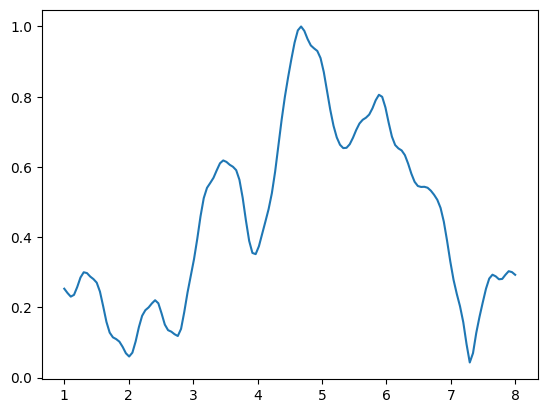

In [ ]:
def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = int(index) // dim
    return tuple(reversed(out))

plot(position4/ METER * 1e3, result[unravel_index(arg, error.shape)].cpu())

In [ ]:
# X1, X2, W1, W2, W3, W4, N1, N2, N3
def print_param_values(incidices):
  print("Slit <-> Blocker: ", float(x1[incidices[0]] / METER * 1e3), "mm", "True: 9.815mm")
  print("Blocker <-> Detector: ", float(x2[incidices[1]] / METER * 1e3), "mm", "True: 489mm")
  print("Slit Width: ", width1[incidices[2]] / METER * 1e6, "µm, ", width2[incidices[3]] / METER * 1e6, "µm", "True: 85µm")
  print("Blocker Width: ", width3[incidices[4]] / METER * 1e6, "mm", "True: 1.778mm")
  print("Detector Width: ", width4[incidices[5]] / METER * 1e6, "mm", "True: 85µm")
  print("Slit Position: ", position1[incidices[6]] / METER * 1e3, "mm, ", position2[incidices[7]] / METER * 1e3, "mm")
  print("Inter-slit Distance: ", abs(position1[incidices[6]] / METER * 1e3 - position2[incidices[7]] / METER * 1e3), "mm", "True: Dependss")
  print("Blocker Position: ", position3[incidices[8]] / METER * 1e3, "mm")

print_param_values(unravel_index(arg, error.shape))

Slit <-> Blocker:  9.8149995803833 mm True: 9.815mm
Blocker <-> Detector:  489.0 mm True: 489mm
Slit Width:  43.15789473684211 µm,  84.21052631578948 µm True: 85µm
Blocker Width:  1778.0 mm True: 1.778mm
Detector Width:  50.0 mm True: 85µm
Slit Position:  1.0 mm,  10.0 mm
Inter-slit Distance:  9.0 mm True: Dependss
Blocker Position:  3.25 mm


In [ ]:
arg

tensor(78740)